# Calculate a 2D emissions grid incorporating COVID-19 effects for short-lived forcers

In [1]:
import netCDF4 as nc
import pandas as pd
import numpy as np
import reverse_geocoder as rg
import matplotlib.pyplot as plt

from datetime import datetime
from global_land_mask import globe

import os
import sys

sys.path.append(os.getcwd())
from utils import copy_netcdf_file, insert_interpolated_point, cutoff_netcdf_time, cleanup_files

In [2]:
# Some data is in days after 2015 rather than years. These years are defined to have 365 days each. 
def convert_years_to_days(year):
    return (year - 2015) * 365

## Instructions for running the code 
Two lines here are guaranteed to need updating each month that the code is run, marked with CHANGE ON UPDATE. File locations (particularly mod_input_folder, which references the data found in https://github.com/Priestley-Centre/COVID19_emissions) will need setting for each environment the code is run in. The input_folder variable references the folder with the original data from Input4MIPs (https://esgf-node.llnl.gov/search/input4mips/) in. 

In [3]:
# The name to affix on the variables output
scenario_string = "4year_v4.8.nc"  # CHANGE ON UPDATE

# We apply a uniform rate to discount some time period between flatrate_start and flatrate_end
flatrate_start =  convert_years_to_days(2020 + 8/12)  # CHANGE ON UPDATE
flatrate_end =  convert_years_to_days(2024)

input_folder = "../input/aerosols/"
output_folder = "../output/aerosols/"

# Input for the aerosols/gases
input_nox = "NOx-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc"
input_bc = "BC-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc"
input_so2 = "SO2-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc"
input_oc = "OC-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc"
input_co = "CO-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc"
input_nh3 = "NH3-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc"
input_nmvoc = "NMVOC-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc"

convert_country_code_file = "convertCountryCodes.csv"
# Input blip is the emissions change, found in the github folder
git_folder = "../../COVID19_emissions_data/"
input_blip = "sector_emissions/Covid_CO2emissions_sectors_July05.csv"
files_to_blip = [
    input_co, 
    input_nh3, input_nmvoc,
    input_oc, input_so2, input_nox, input_bc
]
key_variables = [
    "CO_em_anthro", 
    "NH3_em_anthro", "NMVOC_em_anthro",
    "OC_em_anthro", "SO2_em_anthro", "NOx_em_anthro", "BC_em_anthro"
]

# We don't want data after 2050. NOTE: overwritten if using daily data.
tcutoff = convert_years_to_days(2050.99)

# We want to add timepoints in these years, NOTE: ignored if using daily data. 
years_to_add = [2019, 2021, 2022, 2023, 2025]

use_daily_data_2020_only = False
if use_daily_data_2020_only:
    tstart = convert_years_to_days(2020)
    tcutoff = convert_years_to_days(2021 + 0.000001) # We want to include the leapday, the small number ensures inclusion
    tcutoff_initial = convert_years_to_days(2030 + 1 / 366) # We want to include the first month after 2030
    flatrate_end = tcutoff
    scenario_string = "daily_" + scenario_string
    output_folder = output_folder + "daily/"

In [4]:
# More inputs for the path modification
# Sea modification factors are derived from this file in the Priestly Center github:
sea_file = "national emissions/2020_Emission_change_nationalCO2_high_V3.csv"

# Long-term modification factors found at:
mod_input_folder = git_folder + "global_pathways/"
mod_input_baseline = "Base_pathway.xlsx"
mod_input_4yr = "FourYearBlip_pathway.xlsx"  # This file is identical to the baseline file. 
mod_input_ff = "FossilFuel_pathway.xlsx"
mod_input_2yr= "TwoYearBlip_pathway.xlsx"
mod_input_mg = "ModerateGreen_pathway.xlsx"
mod_input_sg = "StrongGreen_pathway.xlsx"

# Map between key variable name and excel column
path_var_names = {
    "SO2_em_anthro": "sox(MtS/year)",  
    "CO_em_anthro": "co(Mt/year)", 
    "NMVOC_em_anthro": "nmvoc(Mt/year)",
    "NOx_em_anthro": "nox(MtN/year)",
    "BC_em_anthro": "bc(Mt/year)",
    "OC_em_anthro":"oc(Mt/year)", 
    "NH3_em_anthro": "nh3(Mt/year)"
}

pathway_files = [mod_input_4yr]#[mod_input_ff, mod_input_2yr, mod_input_mg, mod_input_sg]

modify_range = np.arange(2022, 2051.01)

In [5]:
assert len(files_to_blip) == len(key_variables) # check input

Lines below this should only be changed if you know what you're doing. 
## Collect and clean the data
We need to make the blip factors consistent with the netCDF data structure. This will require example data, although the results should not depend which example is chosen. 

In [6]:
nox_0 = nc.Dataset(input_folder + input_nox, "r", format="NETCDF4")
blip_factors = pd.read_csv(git_folder + input_blip)
convert_countries = pd.read_csv(input_folder + convert_country_code_file, keep_default_na=False, na_values=['_'])

In [7]:
for dimobj in nox_0.dimensions.values():
...     print(dimobj)

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 720

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 360

<class 'netCDF4._netCDF4.Dimension'>: name = 'sector', size = 8

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 120

<class 'netCDF4._netCDF4.Dimension'>: name = 'bound', size = 2



C:\Users\rlamboll\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  


In [8]:
nox_0.variables["sector"]

<class 'netCDF4._netCDF4.Variable'>
int32 sector(sector)
    long_name: sector
    bounds: sector_bnds
    ids: 0: Agriculture; 1: Energy; 2: Industrial; 3: Transportation; 4: Residential, Commercial, Other; 5: Solvents production and application; 6: Waste; 7: International Shipping
unlimited dimensions: 
current shape = (8,)
filling on, default _FillValue of -2147483647 used

In [9]:
blip_factors = blip_factors[~blip_factors["1"].isna()]
blip_sectors = blip_factors["Sector"].unique()

## Perform the sector weighting


In [10]:
blip_sectors

array(['total', 'surface-transport', 'residential', 'public/commercial',
       'industry', 'international-shipping', 'international-aviation',
       'domestic-aviation', 'power'], dtype=object)

The set of sectors in our blip need to be converted into our sectors in the netCDF case. This uses:
0: Agriculture; 1: Energy; 2: Industrial; 3: Transportation; 4: Residential, Commercial, Other; 5: Solvents production and application; 6: Waste; 7: International Shipping

In [11]:
sector_dict = {
    "surface-transport": 3, "residential": 4, "public/commercial": -4, "industry": 2, 
    "international-shipping":7, "international-aviation": -1, 
    "domestic-aviation": -2, "power": 1, "total": -5
}
# We will manage aviation differently, no change to sector 0 (agri) and no need of the total. Negatives will be ignored
sectors_to_use = [1, 2, 3, 4, 5, 7]  

In [12]:
blip_factors_multi = blip_factors.copy()
blip_factors_multi.drop(["Country", "Base(MtCO2/day)", "Unnamed: 0"], axis=1, inplace=True)
blip_factors_multi["Sector"] = [sector_dict[sect] for sect in blip_factors_multi["Sector"]]
blip_factors_multi.head()

,ISO_A3,Sector,Base%,1,2,3,4,5,6,7,...,357,358,359,360,361,362,363,364,365,366
0,ALB,-5,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,DZA,-5,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.171346,-0.171346,-0.171346,-0.171346,-0.171346,-0.171346,-0.171346,-0.171346,-0.171346,-0.171346
2,AGO,-5,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.095672,-0.095672,-0.095672,-0.095672,-0.095672,-0.095672,-0.095672,-0.095672,-0.095672,-0.095672
3,ARG,-5,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.178931,-0.178931,-0.178931,-0.178931,-0.178931,-0.178931,-0.178931,-0.178931,-0.178931,-0.178931
4,ARM,-5,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [13]:
blip_factors_multi.set_index(blip_factors_multi.columns[:2].to_list(), drop=True, inplace=True)
blip_factors_multi.head()

,,Base%,1,2,3,4,5,6,7,8,9,...,357,358,359,360,361,362,363,364,365,366
ISO_A3,Sector,,,,,,,,,,,,,,,,,,,,,
ALB,-5,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DZA,-5,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.171346,-0.171346,-0.171346,-0.171346,-0.171346,-0.171346,-0.171346,-0.171346,-0.171346,-0.171346
AGO,-5,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.095672,-0.095672,-0.095672,-0.095672,-0.095672,-0.095672,-0.095672,-0.095672,-0.095672,-0.095672
ARG,-5,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.178931,-0.178931,-0.178931,-0.178931,-0.178931,-0.178931,-0.178931,-0.178931,-0.178931,-0.178931
ARM,-5,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [14]:
# We want to average the two sets of sector 4 together in the right ratio
all_countries = blip_factors_multi.index.get_level_values("ISO_A3").unique()
for country in all_countries:
    if (country, 4) in blip_factors_multi.index and (country, -4) in blip_factors_multi.index:
        blip_factors_multi.loc[country, 4] = (
            blip_factors_multi.loc[country, 4].values * 
            blip_factors_multi["Base%"][country, 4] + 
            blip_factors_multi.loc[country, -4].values * blip_factors_multi["Base%"][country, -4]
            ) / (
                blip_factors_multi["Base%"][country, 4] + blip_factors_multi["Base%"][country, -4]
            )
        blip_factors_multi["Base%"][country, 4] = blip_factors_multi["Base%"][country, 4] + \
            blip_factors_multi["Base%"][country, -4]
        blip_factors_multi.drop((country, -4), inplace=True)
    elif (country, -4) in blip_factors_multi.index:
        blip_factors_multi.loc[country, 4] = blip_factors_multi.loc[country, -4]
    elif (country, 4) in blip_factors_multi.index:
        continue
    else:
        print("no data for {}".format(country))

In [15]:
# Test that this produces the right answers
example_factor = blip_factors[
    (blip_factors["ISO_A3"] == "GBR") & (blip_factors["Sector"].isin(["residential", "public/commercial"]))
][["Base%", "100"]]
assert np.isclose(blip_factors_multi.loc["GBR", 4][100], sum(
    example_factor["Base%"] * example_factor["100"]) / sum(example_factor["Base%"])
)

In [16]:
blip_factors_multi

,,Base%,1,2,3,4,5,6,7,8,9,...,357,358,359,360,361,362,363,364,365,366
ISO_A3,Sector,,,,,,,,,,,,,,,,,,,,,
ALB,-5,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DZA,-5,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.171346,-0.171346,-0.171346,-0.171346,-0.171346,-0.171346,-0.171346,-0.171346,-0.171346,-0.171346
AGO,-5,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.095672,-0.095672,-0.095672,-0.095672,-0.095672,-0.095672,-0.095672,-0.095672,-0.095672,-0.095672
ARG,-5,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.178931,-0.178931,-0.178931,-0.178931,-0.178931,-0.178931,-0.178931,-0.178931,-0.178931,-0.178931
ARM,-5,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VEN,1,43.093385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.077074,-0.077074,-0.077074,-0.077074,-0.077074,-0.077074,-0.077074,-0.077074,-0.077074,-0.077074
VNM,1,31.822661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.041597,0.041597,0.041597,0.041597,0.041597,0.041597,0.041597,0.041597,0.041597,0.041597
YEM,1,34.652509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.010251,-0.010251,-0.010251,-0.010251,-0.010251,-0.010251,-0.010251,-0.010251,-0.010251,-0.010251


We additionally assume that solvent production tracks industry.

In [17]:
for country in all_countries:
    blip_factors_multi.loc[(country, 5), :] = blip_factors_multi.loc[(country, 4), :]

In [18]:
blip_factors_multi.index.levels

FrozenList([['AGO', 'ALB', 'ARE', 'ARG', 'ARM', 'AUS', 'AUT', 'AZE', 'BEL', 'BEN', 'BGD', 'BGR', 'BHR', 'BIH', 'BLR', 'BOL', 'BRA', 'BRN', 'BWA', 'CAN', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COL', 'CRI', 'CUB', 'CUW', 'CYP', 'CZE', 'DEU', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESP', 'EST', 'ETH', 'FIN', 'FRA', 'GAB', 'GBR', 'GEO', 'GHA', 'GIB', 'GRC', 'GTM', 'HKG', 'HND', 'HRV', 'HTI', 'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KOR', 'KWT', 'LBN', 'LBY', 'LKA', 'LTU', 'LUX', 'LVA', 'MAR', 'MDA', 'MEX', 'MKD', 'MLT', 'MMR', 'MNE', 'MNG', 'MOZ', 'MUS', 'MYS', 'NAM', 'NER', 'NGA', 'NIC', 'NLD', 'NOR', 'NPL', 'NZL', 'OMN', ...], [-5, -4, -2, -1, 1, 2, 3, 4, 7, 5]])

We also want to similarly average the values for the sea

In [19]:
sea_blip = pd.read_csv(git_folder + sea_file, index_col="Type", )
# The top 2 lines are not helpful so we will drop them
sea_blip.drop(["Name", "Units"], inplace=True)
sea_blip.drop("Unnamed: 0", axis=1, inplace=True)
sea_blip = sea_blip["SEA"]

In [20]:
sea_factors = pd.Series({int(ind): 1 + float(row) / float(sea_blip["Base_em"]) for ind, row in sea_blip.iloc[1:].items()})

In [21]:
sea_factors

1      1.000000
2      1.000000
3      0.998111
4      0.998111
5      0.998111
         ...   
362    0.864030
363    0.864030
364    0.864030
365    0.864030
366    0.864030
Length: 366, dtype: float64

## Derive country and date relation
We need to assign each lat/long a country. This is slightly complicated by the country index being 2 letters in the inverse geocoder but 3 letters in our data.

In [22]:
lat, lon = nox_0.variables["lat"][:], nox_0.variables["lon"][:]

In [23]:
convert_countries_dict = {convert_countries["A2 (ISO)"][i]: convert_countries["A3 (UN)"][i] for i in convert_countries.index}
coords = []
lon_length = len(lon)
for latperm in lat:
    coords = coords + list(zip([latperm] * lon_length, lon))

In [24]:
results = rg.search(coords)

Loading formatted geocoded file...


In [25]:
lat_countries_dict = {coords[i]: convert_countries_dict[results[i]["cc"]] for i in range(len(coords)) 
                      if results[i]["cc"] in convert_countries_dict.keys()}

The process will be faster if we map the other way and use the index rather than the coordinates. We also don't want to analyse the sea in the same way. Note that we will use a definition of land that extends to the edge corners, i.e. by 0.25 degrees in all 4 directions. 

In [26]:
country_coord_dict = {}
sea_coord_dict = {}
land_dist_base = 0.25
for k, v in lat_countries_dict.items():
    lat_loc = np.where(lat.data == k[0])[0][0]
    lon_loc = np.where(lon.data == k[1])[0][0]
    land = (
        globe.is_land(k[0], k[1]) 
        or globe.is_land(k[0] + land_dist_base, k[1] + land_dist_base) 
        or globe.is_land(k[0] - land_dist_base, k[1] - land_dist_base)
        or globe.is_land(k[0] + land_dist_base, k[1] - land_dist_base)
        or globe.is_land(k[0] - land_dist_base, k[1] + land_dist_base)
    )
    if not land:
        sea_coord_dict[lat_loc] = sea_coord_dict.get(lat_loc, [])
        sea_coord_dict[lat_loc].append(lon_loc)
    else:
        country_coord_dict[v] = country_coord_dict.get(v, {})
        country_coord_dict[v][lat_loc] = country_coord_dict[v].get(lat_loc, [])
        country_coord_dict[v][lat_loc].append(lon_loc)

Now we must relate the dates. blip_factors uses days from 2020-01-01, and has values for every day. The netCDFs use days since 2015-01-01, which is 5 * 365 days later and monthly. (The netcdf does not leap days)

In [27]:
date_dif = 5 * 365
date_dif

1825

In [28]:
netCDF_times = nox_0.variables["time"][:]
netCDF_tseries = pd.Series(netCDF_times)
bliptimes = blip_factors_multi.columns[blip_factors_multi.columns != "Base%"]
bliptimes = pd.Series(pd.to_numeric(bliptimes))

In [29]:
time_dict = {}
remaining_times = bliptimes.copy()
mappable_times = netCDF_tseries[(netCDF_tseries > date_dif) & (netCDF_tseries < date_dif + max(bliptimes))]
for t in mappable_times.index[:-1]:
    closeTimes = [bliptime for bliptime in remaining_times if (
        0.5 * (mappable_times[t + 1] + mappable_times[t]) - date_dif > bliptime
    )]
    time_dict[mappable_times[t]] = closeTimes
    remaining_times = remaining_times[~remaining_times.isin(closeTimes)]
time_dict[mappable_times.iloc[-1]] = list(remaining_times)

If we use monthly averaged values, we need to construct them. Otherwise we just rename and neaten for convenience. 

In [30]:
if use_daily_data_2020_only:
    blip_factors_av = blip_factors_multi.copy()
    del blip_factors_av["Base%"]
    blip_factors_av.columns = [int(col) + 365 * 5 for col in blip_factors_av.columns]
    sea_factors_av = sea_factors
    sea_factors_av.index = [int(col) + 365 * 5 for col in sea_factors_av.index]
else:
    blip_factors_av = pd.DataFrame(index=blip_factors_multi.index, columns=time_dict.keys())
    sea_factors_av = pd.Series(index=time_dict.keys(), dtype="float64")
    for key, val in time_dict.items():
        blip_factors_av[key] = blip_factors_multi[list(str(v) for v in val)].mean(axis=1)
        sea_factors_av[key] = sea_factors[val].mean()

In [31]:
sea_factors_av

1840.0    0.993539
1870.0    0.904073
1899.0    0.836614
1930.0    0.793984
1960.0    0.793984
1991.0    0.793984
2021.0    0.864030
2052.0    0.864030
2083.0    0.864030
2113.0    0.864030
2144.0    0.864030
2174.0    0.864030
dtype: float64

In [32]:
def insert_year_of_data(year, data):
    for i in range(1,13):
        insert_interpolated_point(data, (year - 2015) * 365 + data.variables["time"][(i - 1)], 12, i)

## Prepare long-term adjustments
We will adjust dates after 2021 to represent a long-term change in trend. This will rely on the difference between a baseline path and a specific path. 

In [33]:
baseline = pd.read_excel(mod_input_folder + mod_input_baseline, header=0, index_col=1, sheet_name="Emissions")
baseline

,Unnamed: 0,co2_fossil(GtC/year),co2_land(GtC/year),ch4(Mt/year),n2o(Mt(N2)/year),sox(MtS/year),co(Mt/year),nmvoc(Mt/year),nox(MtN/year),bc(Mt/year),...,mcf(kt/year),hcfc22(kt/year),hcfc141b(kt/year),hcfc142b(kt/year),halon1211(kt/year),halon1202(kt/year),halon1301(kt/year),halon2402(kt/year),ch3br(kt/year),ch3cl(kt/year)
year,,,,,,,,,,,,,,,,,,,,,
1765.041667,0,0.003017,0.106683,20.916467,0.072541,1.248525,352.784696,60.597387,3.877079,2.123054,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,157.267,3100.211
1765.125000,1,0.003050,0.106850,20.911000,0.072655,1.247975,352.488688,60.533163,3.877638,2.121962,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,157.267,3100.211
1765.208333,2,0.003083,0.107017,20.905533,0.072769,1.247425,352.192679,60.468937,3.878196,2.120871,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,157.267,3100.211
1765.291667,3,0.003117,0.107183,20.900067,0.072883,1.246875,351.896671,60.404712,3.878754,2.119779,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,157.267,3100.211
1765.375000,4,0.003150,0.107350,20.894600,0.072997,1.246325,351.600662,60.340488,3.879313,2.118688,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,157.267,3100.211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2050.625000,3427,11.386316,0.166287,310.885081,7.222736,24.056597,655.053968,158.765681,38.719807,4.616196,...,0.0,54.809500,25.770750,1.883250,0.274500,0.0,0.189375,0.001375,155.925,3511.082
2050.708333,3428,11.386316,0.166287,310.885081,7.222736,24.056597,655.053968,158.765681,38.719807,4.616196,...,0.0,54.163167,25.659917,1.870083,0.272833,0.0,0.188625,0.001292,155.925,3511.082
2050.791667,3429,11.386316,0.166287,310.885081,7.222736,24.056597,655.053968,158.765681,38.719807,4.616196,...,0.0,53.516833,25.549083,1.856917,0.271167,0.0,0.187875,0.001208,155.925,3511.082


In [34]:
month_dict = {i: baseline.index[i] - 1765 for i in range(12)}
def make_day_into_year(days):
    return 2015 + days // 365 + month_dict[(days % 365) // 30]
make_day_into_year( 365 * 6 + 2)

2021.041666666667

## Perform the emissions blip
We now have a mapping between times and locations and the emissions we want. 

In [35]:
all_valid_countries = [c for c in all_countries if c in country_coord_dict.keys()]
if use_daily_data_2020_only:
    day_range = list(np.arange(tstart, tcutoff))
    to_interp_range = [day for day in day_range if day not in nox_0.variables["time"][:]]
else:
    monthly_range = [
        date for date in nox_0.variables["time"][:] if (date >= convert_years_to_days(min(modify_range)))
        and (date < convert_years_to_days(max(modify_range)))
    ]

In [36]:
nox_0.close()
if use_daily_data_2020_only:
    varrate_timeinds = [
        ind for ind in blip_factors_av if (ind < flatrate_start)
    ]
    varrate_ind = max(blip_factors_av.columns)
else:
    varrate_timeinds = [ind for ind in blip_factors_av.columns if ind < flatrate_start]
    varrate_ind = max(blip_factors_av.columns)
base_string = "_baseline.nc"
working_string = "_workings.nc"
cut_str = "cut_"
crop_str = "_crop.nc"

In [37]:
varrate_timeinds

[1840.0, 1870.0, 1899.0, 1930.0, 1960.0, 1991.0, 2021.0, 2052.0]

Working on data for CO_em_anthro
Added years [2019, 2021, 2022, 2023, 2025]
cropped baseline
ALB
DZA
AGO
ARG
ARM
Key error for sector 7, country ARM
AUS
AUT
AZE
BHR
BGD
BLR
Key error for sector 7, country BLR
BEL
BEN
BOL
Key error for sector 7, country BOL
BIH
Key error for sector 7, country BIH
BWA
Key error for sector 7, country BWA
BRA
BRN
Key error for sector 7, country BRN
BGR
KHM
Key error for sector 7, country KHM
CMR
Key error for sector 7, country CMR
CAN
CHL
CHN
COL
COG
Key error for sector 7, country COG
CRI
Key error for sector 7, country CRI
CIV
HRV
CUB
CYP
CZE
Key error for sector 7, country CZE
PRK
Key error for sector 7, country PRK
COD
Key error for sector 7, country COD
DNK
DOM
Key error for sector 7, country DOM
ECU
EGY
SLV
Key error for sector 7, country SLV
ERI
Key error for sector 7, country ERI
EST
ETH
Key error for sector 1, country ETH
Key error for sector 7, country ETH
FIN
FRA
GAB
GEO
Key error for sector 7, country GEO
DEU
GHA
Key error for sector 7, country

HTI
Key error for sector 7, country HTI
HND
HKG
HUN
Key error for sector 7, country HUN
ISL
IND
IDN
IRN
IRQ
IRL
ISR
ITA
JAM
JPN
JOR
KAZ
KEN
KOR
RKS
Key error for sector 7, country RKS
KWT
KGZ
Key error for sector 7, country KGZ
LVA
LBN
Key error for sector 7, country LBN
LBY
LTU
LUX
Key error for sector 7, country LUX
MYS
MUS
MEX
MDA
Key error for sector 7, country MDA
MNG
Key error for sector 7, country MNG
MNE
Key error for sector 7, country MNE
MAR
MOZ
Key error for sector 7, country MOZ
MMR
Key error for sector 7, country MMR
NAM
Key error for sector 7, country NAM
NPL
Key error for sector 1, country NPL
Key error for sector 7, country NPL
NLD
NZL
NIC
Key error for sector 7, country NIC
NER
Key error for sector 7, country NER
NGA
MKD
Key error for sector 7, country MKD
NOR
OMN
PAK
PAN
PRY
Key error for sector 1, country PRY
Key error for sector 7, country PRY
PER
PHL
POL
PRT
QAT
Key error for sector 7, country QAT
ROU
RUS
SAU
SEN
SRB
SGP
SVK
Key error for sector 7, country SVK
SVN


PHL
POL
PRT
QAT
Key error for sector 7, country QAT
ROU
RUS
SAU
SEN
SRB
SGP
SVK
Key error for sector 7, country SVK
SVN
ZAF
SSD
Key error for sector 7, country SSD
ESP
LKA
SDN
SUR
SWE
CHE
Key error for sector 7, country CHE
SYR
TWN
TJK
Key error for sector 7, country TJK
TZA
THA
TGO
TTO
TUN
TUR
TKM
Key error for sector 7, country TKM
UKR
Key error for sector 7, country UKR
ARE
GBR
USA
URY
UZB
Key error for sector 7, country UZB
VEN
VNM
YEM
ZMB
Key error for sector 7, country ZMB
ZWE
Key error for sector 7, country ZWE
Adding path for FourYearBlip.nc


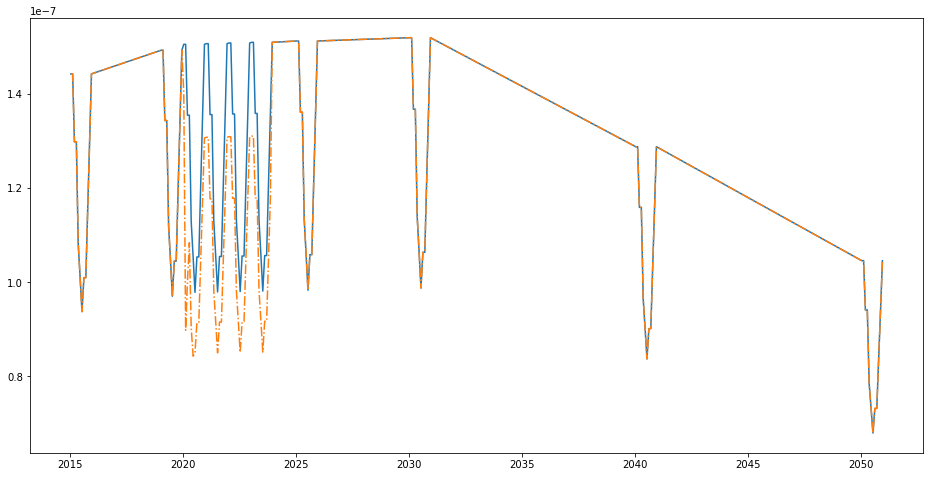

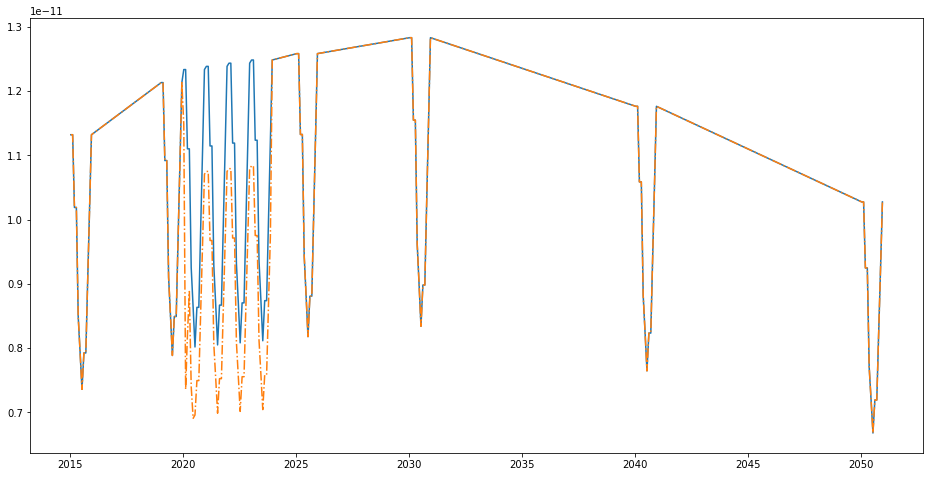

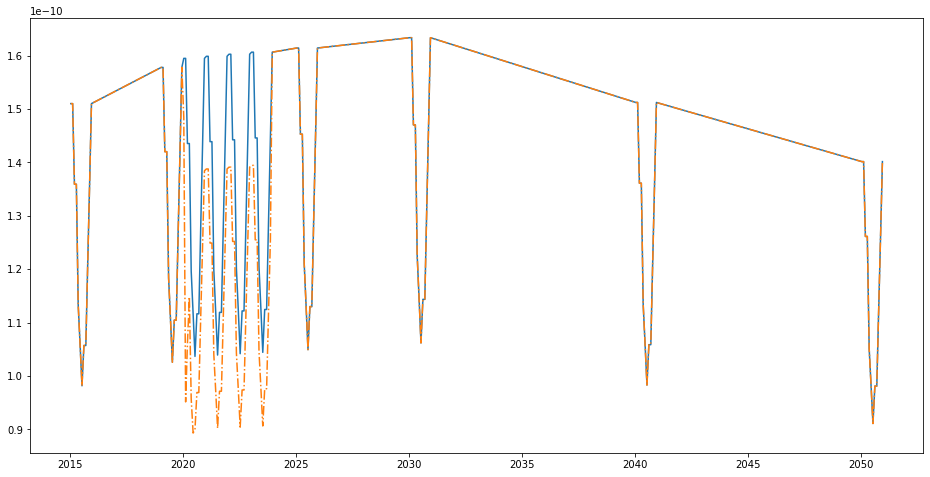

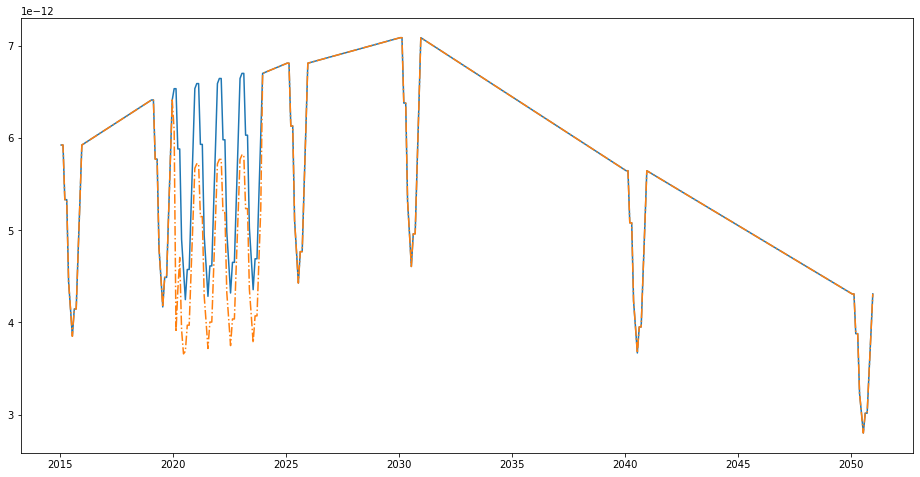

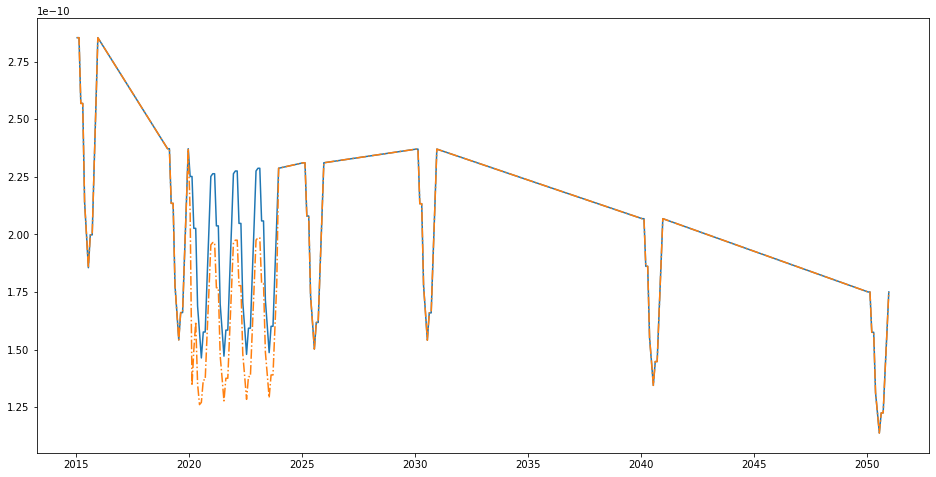

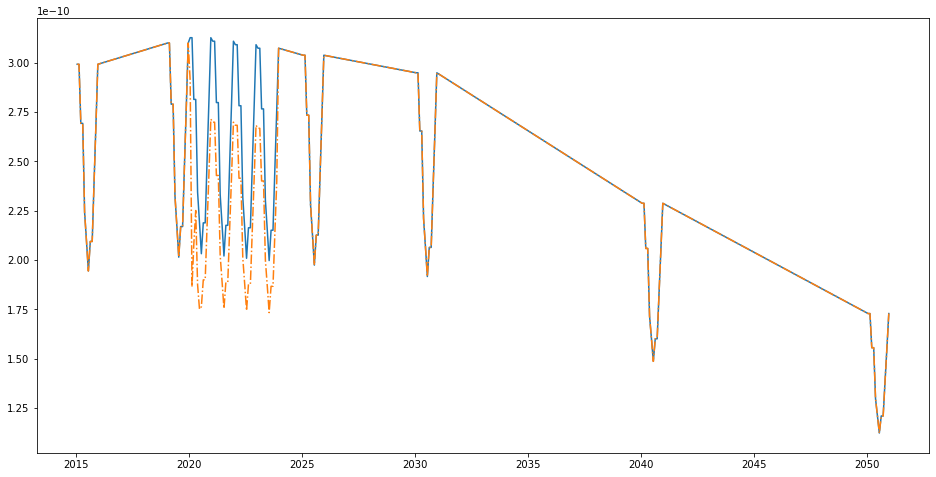

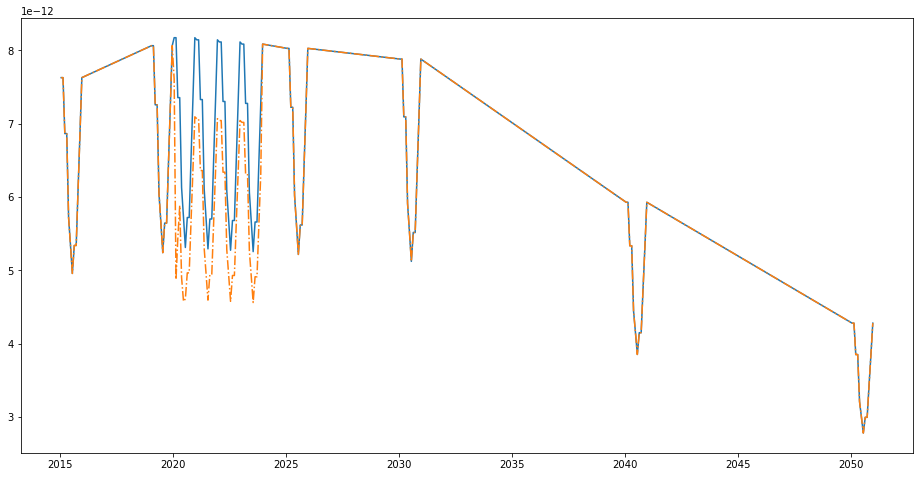

In [38]:
for fileind in range(len(files_to_blip)):
    file = files_to_blip[fileind]
    # Insert interpolated timepoints
    if use_daily_data_2020_only:
        data = cutoff_netcdf_time(
            input_folder, output_folder, file, tcutoff_initial, scenario_string=scenario_string + cut_str, compress=False
        )
        print("Working on data for {}".format(key_variables[fileind]))
        # Insert all the required days
        start = datetime.now()
        for day in to_interp_range:
            insert_interpolated_point(data, day, 1, 1)
        end = datetime.now()
        # We now want to cut off the extraneous times. 
        start = datetime.now()
        data = cutoff_netcdf_time(
            output_folder, output_folder, cut_str + file + scenario_string + cut_str, tcutoff, "", remove_string=cut_str,
            compress=False, tstart=tstart
        )
        end = datetime.now()
        print("Finished cropping data. Took {}".format(end - start))
        data.close()
        # Now we copy the baseline data
        data = copy_netcdf_file(
            cut_str + file + scenario_string, output_folder, output_folder, 
            scenario_string=base_string, compress=True, remove_string=crop_str
        )
    else:
        data = cutoff_netcdf_time(
            input_folder, output_folder, file, tcutoff, scenario_string=scenario_string, compress=False
        )
        print("Working on data for {}".format(key_variables[fileind]))
        # Insert interpolated points in 2019, 2021 and 2023.
        for year_to_add in years_to_add:
            insert_year_of_data(year_to_add, data)
        data.close()
        print("Added years {}".format(years_to_add))
        # This is the correct file for the baseline, but we want it compressed.
        data = copy_netcdf_file(
            cut_str + file + scenario_string, output_folder, output_folder, scenario_string=base_string, compress=True
        )
    data.close()
    print("cropped baseline")
    # Other files will need modification
    data = copy_netcdf_file(
        cut_str + file + scenario_string, output_folder, output_folder, scenario_string=working_string, compress=False
    )
    output = data.variables[key_variables[fileind]][:, :, :, :]
    plt.figure(figsize=(16, 8))
    plt.plot(data.variables["time"][:]/365 + 2015, output[:,  2, 262, 605])
    flatrate_timeinds = np.where(
        (data.variables["time"][:] <= flatrate_end) & (data.variables["time"][:] >= flatrate_start)
    )[0]
    min_flat = min(flatrate_timeinds)
    max_flat = max(flatrate_timeinds)
    
    # Modify the shipping emissions in the international sea by a global amount
    sector = 7
    for time in varrate_timeinds:
        timeind = np.where(data.variables["time"][:] == time)[0]
        mult_fact = sea_factors_av[time] # Note that adding 1 has already been done here. 
        if mult_fact != 1.0: #This saves operations
            for lati, longi in sea_coord_dict.items():
                output[timeind, sector, lati, longi] *= mult_fact
    mult_fact = sea_factors_av.iloc[-1]
    for lati, longi in sea_coord_dict.items():
        output[min_flat:max_flat, sector, lati, longi] *= mult_fact
    
    # Modify points by a time-and country dependent value in 2020 - 2021
    for country in  all_valid_countries:
        print(country)
        for time in varrate_timeinds:
            timeind = np.where(data.variables["time"][:] == time)[0]
            for sector in sectors_to_use:
                try:
                    mult_fact = blip_factors_av[time].loc[country, sector] + 1
                    if mult_fact != 1.0: #This saves operations
                        for lati, longi in country_coord_dict[country].items():
                            output[timeind, sector, lati, longi] *= mult_fact
                except KeyError as e:
                    continue
        # Then make the changes for all of the flat rate times (same factor)
        for sector in sectors_to_use:
            try:
                mult_fact = blip_factors_av[varrate_ind].loc[country, sector] + 1
                if mult_fact != 1.0: #This saves operations
                    for lati, longi in country_coord_dict[country].items():
                        output[min_flat:max_flat, sector, lati, longi] *= mult_fact
            except KeyError as e:
                print("Key error for sector {}, country {}".format(sector, country))
    data.variables[key_variables[fileind]][:, :, :, :] = output
    data.close()
    if use_daily_data_2020_only:
        data = copy_netcdf_file(
            cut_str + file + scenario_string + working_string, output_folder, output_folder, 
            scenario_string="_1_year.nc", compress=True, remove_string=working_string
        )
        data.close()
    else:
        for pathind in range(len(pathway_files)):
            path_file = pathway_files[pathind]
            path_string = path_file.split("_")[0] + ".nc"
            print("Adding path for {}".format(path_string))
            data = copy_netcdf_file(
                cut_str + file + scenario_string + working_string, output_folder, output_folder, "_", remove_string=working_string
            )
            output = data.variables[key_variables[fileind]][:, :, :, :]
            path_df = pd.read_excel(mod_input_folder + path_file, header=0, index_col=1, sheet_name="Emissions")
            for time in monthly_range:
                timeind = np.where(data.variables["time"][:] == time)
                time_factor = path_df[path_var_names[key_variables[fileind]]].loc[
                    make_day_into_year(time)
                ] / baseline[path_var_names[key_variables[fileind]]].loc[make_day_into_year(time)]
                output[timeind, ...] = (output[timeind, :]) * time_factor 
            plt.plot(
                data.variables["time"][:]/365 + 2015, output[:,  2, 262, 605], linestyle ="-."
            )
            data.variables[key_variables[fileind]][:, :, :, :] = output
            data.close()
            # Finally compress this to make a useable file. 
            data = copy_netcdf_file(
                cut_str + file + scenario_string + "_", output_folder, output_folder, scenario_string=path_string, compress=True
            )
            data.close()

In [39]:
# This function will delete the files we don't want
cleanup_files(output_folder, working_string, scenario_string)

Deleting files ['cut_BC-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc4year_v4.8.nc', 'cut_BC-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc4year_v4.8.nc_', 'cut_BC-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc4year_v4.8.nc_workings.nc', 'cut_CO-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc4year_v4.8.nc', 'cut_CO-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc4year_v4.8.nc_', 'cut_CO-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc4year_v4.8.nc_workings.nc', 'cut_NH3-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc4year_v4.8.nc', 'cut_NH3-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc4year_v4.8.nc_', 'cut_NH3-em

In [40]:
cleanup_files(output_folder, working_string, "cut_")

Deleting files []


## SANDBOX
Code below this line will break and are not for general use, but may be useful to run (in some order) to when trying to understand the data. 

In [41]:
stop  # unassigned variable stops execution

NameError: name 'stop' is not defined

In [ ]:
data.close()

In [ ]:
data2.close()

In [ ]:
data = nc.Dataset("../output/aerosols/cut_CO-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.ncv4.7.nc_baseline.nc")
data2 = nc.Dataset("../output/aerosols/cut_CO-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.ncv4.7.nc_TwoYearBlip.nc")

In [ ]:
all_vals = data.variables["CO_em_anthro"][:]
all_vals2 = data2.variables["CO_em_anthro"][:]

In [ ]:
output=data.variables[key_variables[fileind]][...]

In [ ]:
data=nc.Dataset(output_folder + cut_str + file + scenario_string + "_1_year.nc")

In [ ]:
data2.variables["time"][50]/365 + 15

In [ ]:
data = copy_netcdf_file(
            cut_str + file + scenario_string + working_string, output_folder, output_folder, 
            scenario_string="", remove_string=working_string
        )

In [ ]:
plt.plot(data.variables["time"][:], data.variables[key_variables[fileind]][:, 2, 262, 605])

In [ ]:
for fileind in range(len(files_to_blip)):
    file = files_to_blip[fileind]
    print(file)
    for pathind in range(len(pathway_files)):
            path_file = pathway_files[pathind]
            path_string = path_file.split("_")[0] + ".nc"
            print("Adding path for {}".format(path_string))
            data = copy_netcdf_file(
                cut_str + file + scenario_string + working_string, output_folder, output_folder, "_", remove_string=working_string
            )
            output = data.variables[key_variables[fileind]][:, :, :, :]
            path_df = pd.read_excel(mod_input_folder + path_file, header=0, index_col=1, sheet_name="Emissions")
            for time in monthly_range:
                timeind = np.where(data.variables["time"][:] == time)
                time_factor = path_df[path_var_names[key_variables[fileind]]].loc[
                    make_day_into_year(time)
                ] / baseline[path_var_names[key_variables[fileind]]].loc[make_day_into_year(time)]
                output[timeind, ...] = (output[timeind, :]) * time_factor 
            plt.plot(
                data.variables["time"][:]/365 + 2015, output[:,  2, 262, 605], linestyle ="-."
            )
            data.variables[key_variables[fileind]][:, :, :, :] = output
            data.close()
            # Finally compress this to make a useable file. 
            data = copy_netcdf_file(
                cut_str + file + scenario_string + "_", output_folder, output_folder, scenario_string=path_string, compress=True
            )
            data.close()

In [ ]:
t = 35
plt.figure(figsize=(16, 8))
plt.imshow(np.log((output2[-1, 7, ::-1, :] / output[-1, 7, ::-1, :]) * 1e20 + 1))

In [ ]:
t = 29
plt.plot(output[-1, 7, ::-1, :] / output2[-1, 7, ::-1, :])

In [ ]:
working_string = "_workings.nc"

In [ ]:
plt.figure(figsize=(16, 8))
plt.imshow(np.log((all_vals2[30, 7, ::-1, :]) * 1e20 + 1))

In [ ]:
data2 = nc.Dataset(
    "../output/aerosols/cut_BC-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.ncv4.nc_baseline.nc"
)

In [ ]:

max_flat

In [ ]:
for pathind in [2]:
    path_file = pathway_files[pathind]
    path_string = path_file.split("_")[0] + ".nc"
    data = copy_netcdf_file(file + scenario_string, output_folder, output_folder, "__")
    output = data.variables[key_variables[fileind]][:, :, :, :]
    path_df = pd.read_excel(mod_input_folder + path_file, header=0, index_col=1, sheet_name="Emissions")

In [ ]:
plt.plot(data.variables["time"][:]/365 + 2015, output[:,  2, 262, 605])
for time in monthly_range:
    timeind = np.where(data.variables["time"][:] == time)
    time_factor = path_df[path_var_names[key_variables[fileind]]].loc[
        make_day_into_year(time)
    ] / baseline[path_var_names[key_variables[fileind]]].loc[make_day_into_year(time)]
    output[timeind, ...] = (output[timeind, :]) * time_factor 
plt.plot(data.variables["time"][:]/365 + 2015, data.variables[key_variables[fileind]][:,  2, 262, 605])


In [ ]:
plt.figure(figsize=(16, 8))
data = nc.Dataset(input_folder + file)
plt.plot(data.variables["time"][:100] / 365, data.variables[key_variables[fileind]][:100, 2, 262, 605])
data = nc.Dataset(output_folder +"cut_" + file + scenario_string + "_" + path_string)
plt.plot(data.variables["time"][:100] / 365, data.variables[key_variables[fileind]][:100, 2, 262, 605], linestyle= "--")
